In [1]:
# Import Required Libraries
import os
import shutil
import pathlib

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
# !unzip -qq archive.zip

2023-12-21 02:29:17.044514: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 02:29:17.049133: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-21 02:29:17.167399: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-21 02:29:17.181071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 02:29:18.957977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Check Tensorflow Version
import tensorflow
tensorflow.__version__

'2.13.1'

# Exploratory Data Analysis(EDA)

In [3]:
base_dir = './'
tumorous_imgs = [fn for fn in os.listdir(f'{base_dir}/yes') if fn.endswith('.jpg')]
non_tumorous_imgs = [fn for fn in os.listdir(f'{base_dir}/no') if fn.endswith('.jpg')]

num_tumorous_imgs = len(tumorous_imgs)
num_non_tumorous_imgs = len(non_tumorous_imgs)

len(non_tumorous_imgs), len(tumorous_imgs)

(1500, 1500)

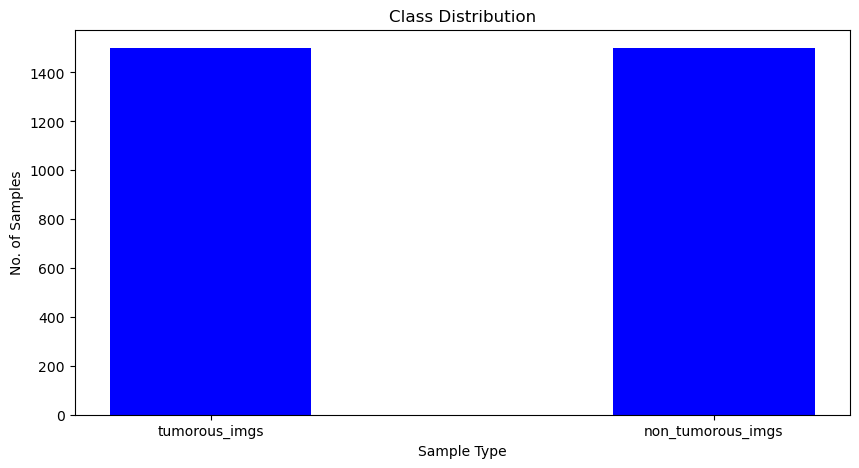

In [4]:
data = {'tumorous_imgs':len(tumorous_imgs), 'non_tumorous_imgs':len(non_tumorous_imgs)}
Samples = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(Samples, values, color ='blue', 
        width = 0.4)
 
plt.xlabel("Sample Type")
plt.ylabel("No. of Samples")
plt.title("Class Distribution")
plt.show()

In [5]:
def show_image_samples(gen):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        #index=np.argmax(labels[i])
        #class_name=classes[index]
        if labels[i] == 1:
            class_name= "Tumorous"
        elif labels[i] ==0:
            class_name= "Non-Tumorous"
        else:
            class_name= "Indeterminate"
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [6]:
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO

IMG_PATH = "./"

# split the data by train/val/test
# ignored = {"pred","Br35H-Mask-RCNN"}
accepted = {"no", "yes"}
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if CLASS in accepted:
        if not CLASS.startswith('.'):
            IMG_NUM = len(os.listdir(IMG_PATH +"/"+ CLASS))
            for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +"/"+ CLASS)):
                img = IMG_PATH+ '/' +  CLASS + '/' + FILE_NAME
                if n < 0.20*IMG_NUM:
                    shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
                elif n < 0.80*IMG_NUM:
                    shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
                else:
                    shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists


In [7]:
# Set up paths to training, validation and test data
train_dir = './TRAIN'
val_dir = './VAL'
test_dir = './TEST'

In [8]:
# Initialize Model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2023-12-21 02:29:23.152515: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 02:29:23.227435: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
# Compile Model
model.compile(loss='binary_crossentropy',\
             optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

In [10]:
# Initialize ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# Training Data Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    shuffle=True,
                                                    class_mode='binary')

Found 1800 images belonging to 2 classes.


In [12]:
# Validation Data Generator
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        shuffle=True,
                                                        class_mode='binary')

Found 600 images belonging to 2 classes.


In [13]:
# Test Data Generator
test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        shuffle=True,
                                                        class_mode='binary')

Found 600 images belonging to 2 classes.


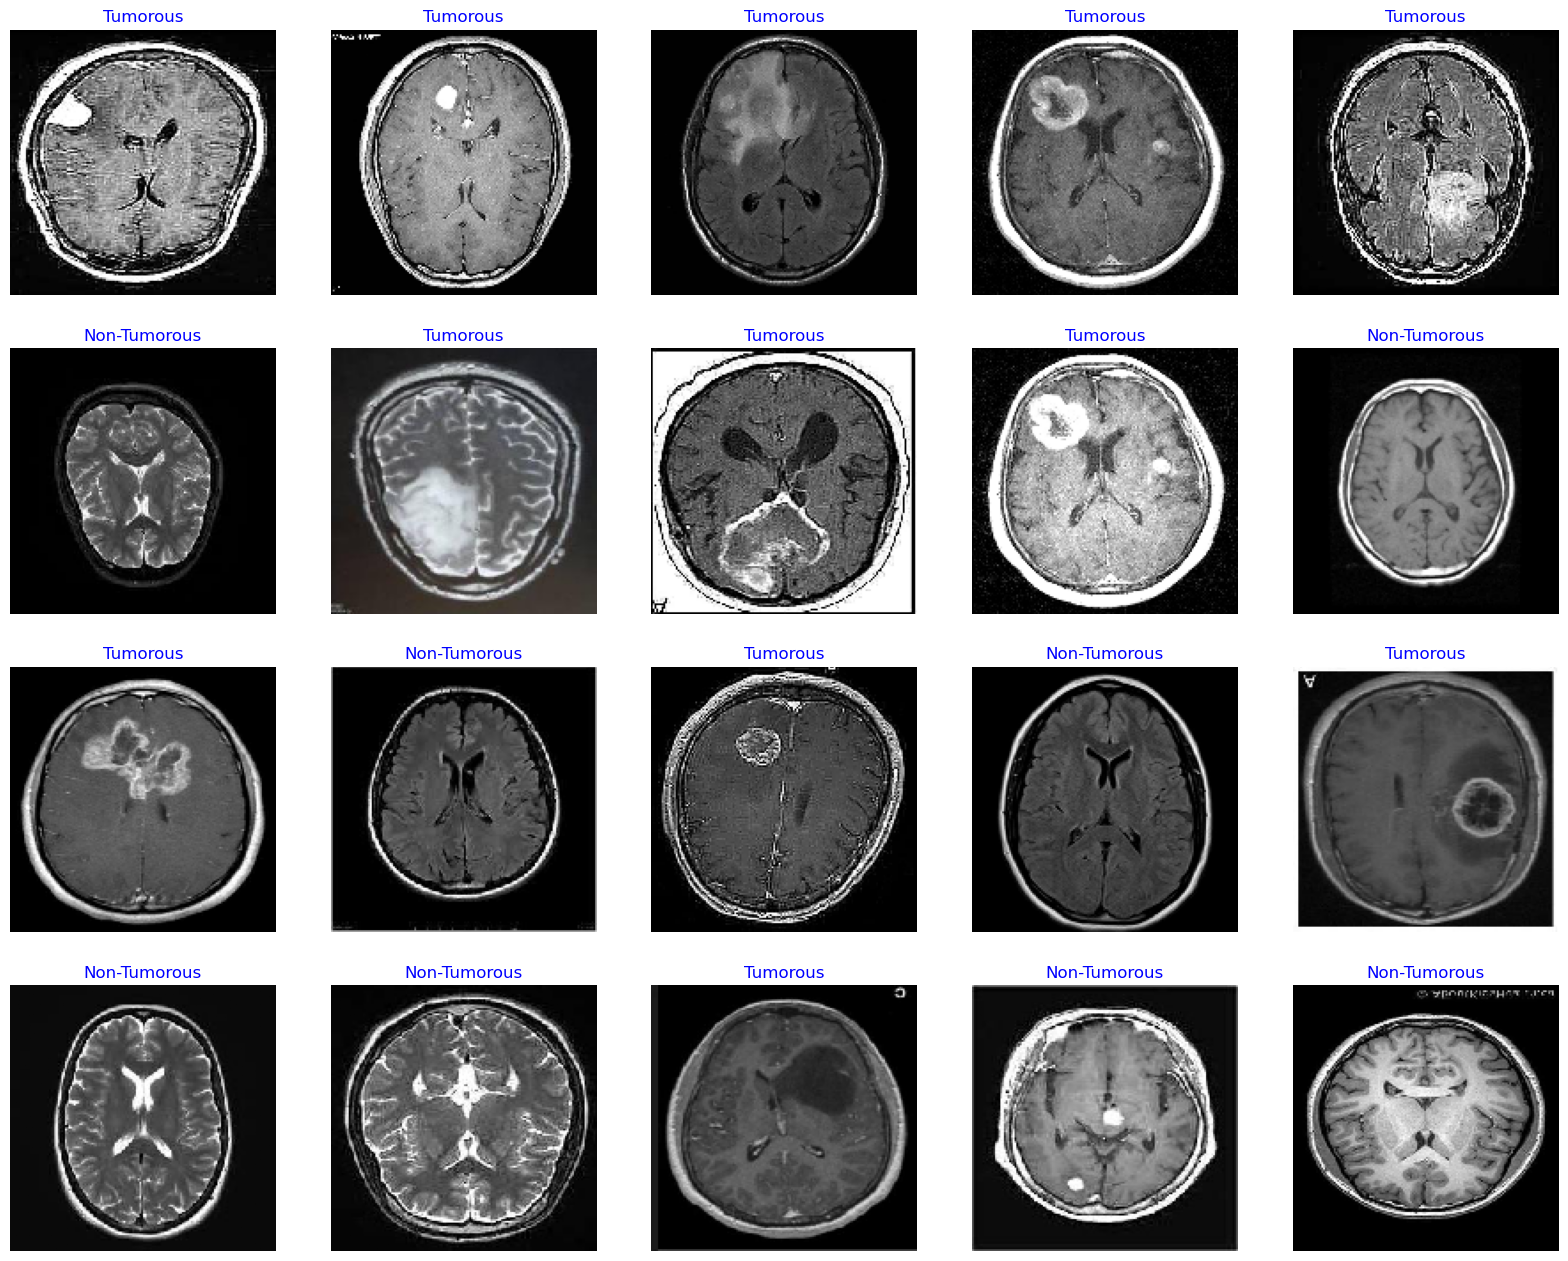

In [14]:
show_image_samples(train_generator)

In [15]:
# Inspect Data & Labels Batch Shape
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


In [16]:
# Train the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_original_data.tf",
        save_best_only=True,
        monitor="val_loss",
        save_format="tf")
]
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/30
90/90 [==============================] - ETA: 0s - loss: 0.5266 - acc: 0.7489INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 17s 174ms/step - loss: 0.5266 - acc: 0.7489 - val_loss: 0.4689 - val_acc: 0.7700
Epoch 2/30
90/90 [==============================] - ETA: 0s - loss: 0.4279 - acc: 0.8100INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 15s 171ms/step - loss: 0.4279 - acc: 0.8100 - val_loss: 0.3907 - val_acc: 0.8267
Epoch 3/30
90/90 [==============================] - ETA: 0s - loss: 0.3615 - acc: 0.8456INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 15s 168ms/step - loss: 0.3615 - acc: 0.8456 - val_loss: 0.3328 - val_acc: 0.8483
Epoch 4/30
90/90 [==============================] - ETA: 0s - loss: 0.2789 - acc: 0.8928INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 15s 169ms/step - loss: 0.2789 - acc: 0.8928 - val_loss: 0.2800 - val_acc: 0.8750
Epoch 5/30
90/90 [==============================] - 14s 159ms/step - loss: 0.2351 - acc: 0.9128 - val_loss: 0.3857 - val_acc: 0.8067
Epoch 6/30
90/90 [==============================] - ETA: 0s - loss: 0.1756 - acc: 0.9500INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 15s 165ms/step - loss: 0.1756 - acc: 0.9500 - val_loss: 0.2117 - val_acc: 0.9283
Epoch 7/30
90/90 [==============================] - 14s 156ms/step - loss: 0.1545 - acc: 0.9528 - val_loss: 0.2329 - val_acc: 0.9133
Epoch 8/30
90/90 [==============================] - ETA: 0s - loss: 0.1327 - acc: 0.9611INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 16s 173ms/step - loss: 0.1327 - acc: 0.9611 - val_loss: 0.1588 - val_acc: 0.9583
Epoch 9/30
90/90 [==============================] - ETA: 0s - loss: 0.0875 - acc: 0.9822INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 15s 166ms/step - loss: 0.0875 - acc: 0.9822 - val_loss: 0.1429 - val_acc: 0.9500
Epoch 10/30
90/90 [==============================] - 14s 159ms/step - loss: 0.0704 - acc: 0.9839 - val_loss: 0.1531 - val_acc: 0.9417
Epoch 11/30
90/90 [==============================] - ETA: 0s - loss: 0.0577 - acc: 0.9894INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 16s 178ms/step - loss: 0.0577 - acc: 0.9894 - val_loss: 0.1227 - val_acc: 0.9617
Epoch 12/30
90/90 [==============================] - ETA: 0s - loss: 0.0492 - acc: 0.9917INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 15s 171ms/step - loss: 0.0492 - acc: 0.9917 - val_loss: 0.1181 - val_acc: 0.9617
Epoch 13/30
90/90 [==============================] - ETA: 0s - loss: 0.0425 - acc: 0.9900INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 15s 167ms/step - loss: 0.0425 - acc: 0.9900 - val_loss: 0.1163 - val_acc: 0.9617
Epoch 14/30
90/90 [==============================] - 14s 156ms/step - loss: 0.0310 - acc: 0.9972 - val_loss: 0.1172 - val_acc: 0.9650
Epoch 15/30
90/90 [==============================] - 14s 152ms/step - loss: 0.0265 - acc: 0.9972 - val_loss: 0.1302 - val_acc: 0.9567
Epoch 16/30
90/90 [==============================] - ETA: 0s - loss: 0.0219 - acc: 0.9983INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 15s 170ms/step - loss: 0.0219 - acc: 0.9983 - val_loss: 0.1115 - val_acc: 0.9667
Epoch 17/30
90/90 [==============================] - 14s 156ms/step - loss: 0.0197 - acc: 0.9983 - val_loss: 0.1243 - val_acc: 0.9583
Epoch 18/30
90/90 [==============================] - 14s 152ms/step - loss: 0.0162 - acc: 0.9994 - val_loss: 0.1174 - val_acc: 0.9650
Epoch 19/30
90/90 [==============================] - 14s 155ms/step - loss: 0.0129 - acc: 0.9994 - val_loss: 0.1182 - val_acc: 0.9633
Epoch 20/30
90/90 [==============================] - ETA: 0s - loss: 0.0108 - acc: 0.9994INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 15s 167ms/step - loss: 0.0108 - acc: 0.9994 - val_loss: 0.1088 - val_acc: 0.9717
Epoch 21/30
90/90 [==============================] - ETA: 0s - loss: 0.0095 - acc: 1.0000INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


INFO:tensorflow:Assets written to: convnet_from_scratch_original_data.tf/assets


90/90 [==============================] - 15s 166ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.1076 - val_acc: 0.9633
Epoch 22/30
90/90 [==============================] - 14s 151ms/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.1106 - val_acc: 0.9700
Epoch 23/30
90/90 [==============================] - 14s 154ms/step - loss: 0.0084 - acc: 1.0000 - val_loss: 0.1237 - val_acc: 0.9633
Epoch 24/30
90/90 [==============================] - 14s 155ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.1142 - val_acc: 0.9700
Epoch 25/30
90/90 [==============================] - 14s 157ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.1137 - val_acc: 0.9683
Epoch 26/30
90/90 [==============================] - 14s 152ms/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.1160 - val_acc: 0.9683
Epoch 27/30
90/90 [==============================] - 14s 155ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.1228 - val_acc: 0.9650
Epoch 28/30
90/90 [==============================] - 14s 153ms/step - loss

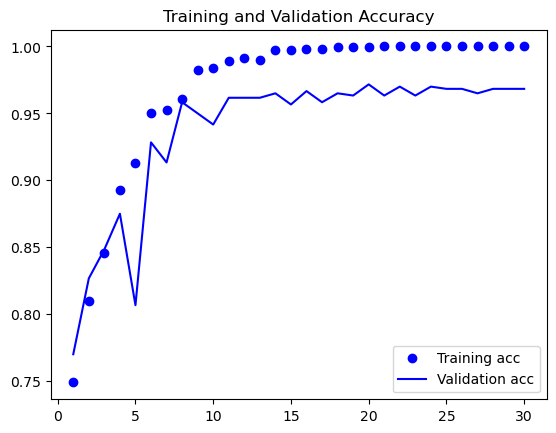

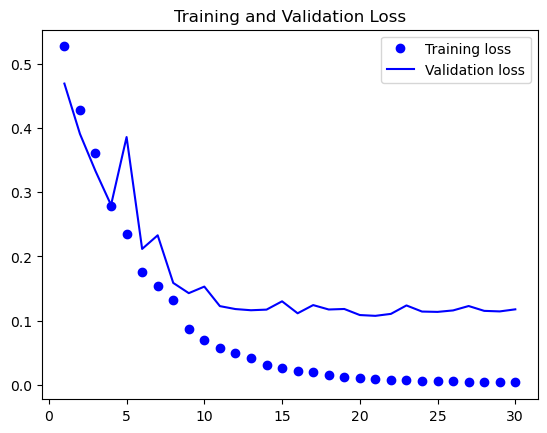

In [17]:
# Plot loss and accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [18]:
# Compute Median Training Accuracy
acc_median = np.median(acc)
acc_median

0.9977777898311615

In [19]:
# Initialize Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,       
    width_shift_range=0.1,                               
    height_shift_range=0.1, 
    shear_range=0.1, 
    brightness_range=(0.3, 1.0),                 
    horizontal_flip=True,                             
    vertical_flip=True,
    fill_mode='nearest')

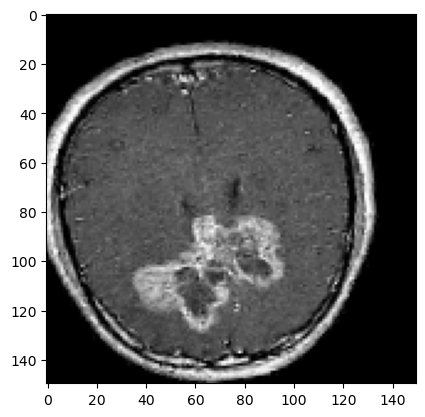

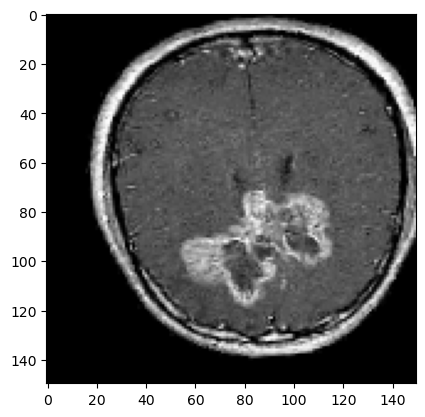

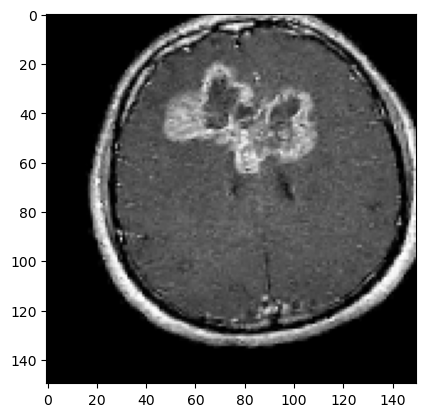

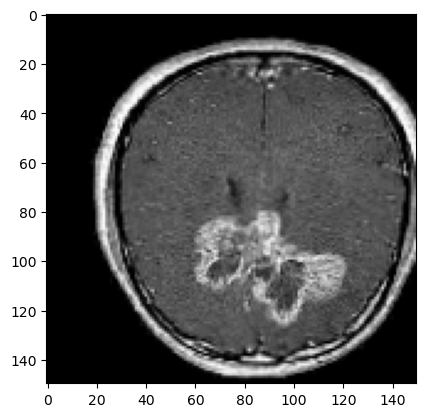

In [20]:
# Plot Input Images
fnames = [os.path.join(train_dir+"/YES", fname) for
    fname in os.listdir(train_dir+"/YES")]

img_path = fnames[0]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [21]:
# Training Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,       
    width_shift_range=0.1,                               
    height_shift_range=0.1, 
    shear_range=0.1, 
    brightness_range=(0.3, 1.0),                 
    horizontal_flip=True,                             
    vertical_flip=True,
    fill_mode='nearest')

In [22]:
# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
# Initialize Training Data Generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150), 
                                                    batch_size=32, 
                                                    class_mode='binary')

Found 1800 images belonging to 2 classes.


In [24]:
# Initialize Validation Data Generator
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 600 images belonging to 2 classes.


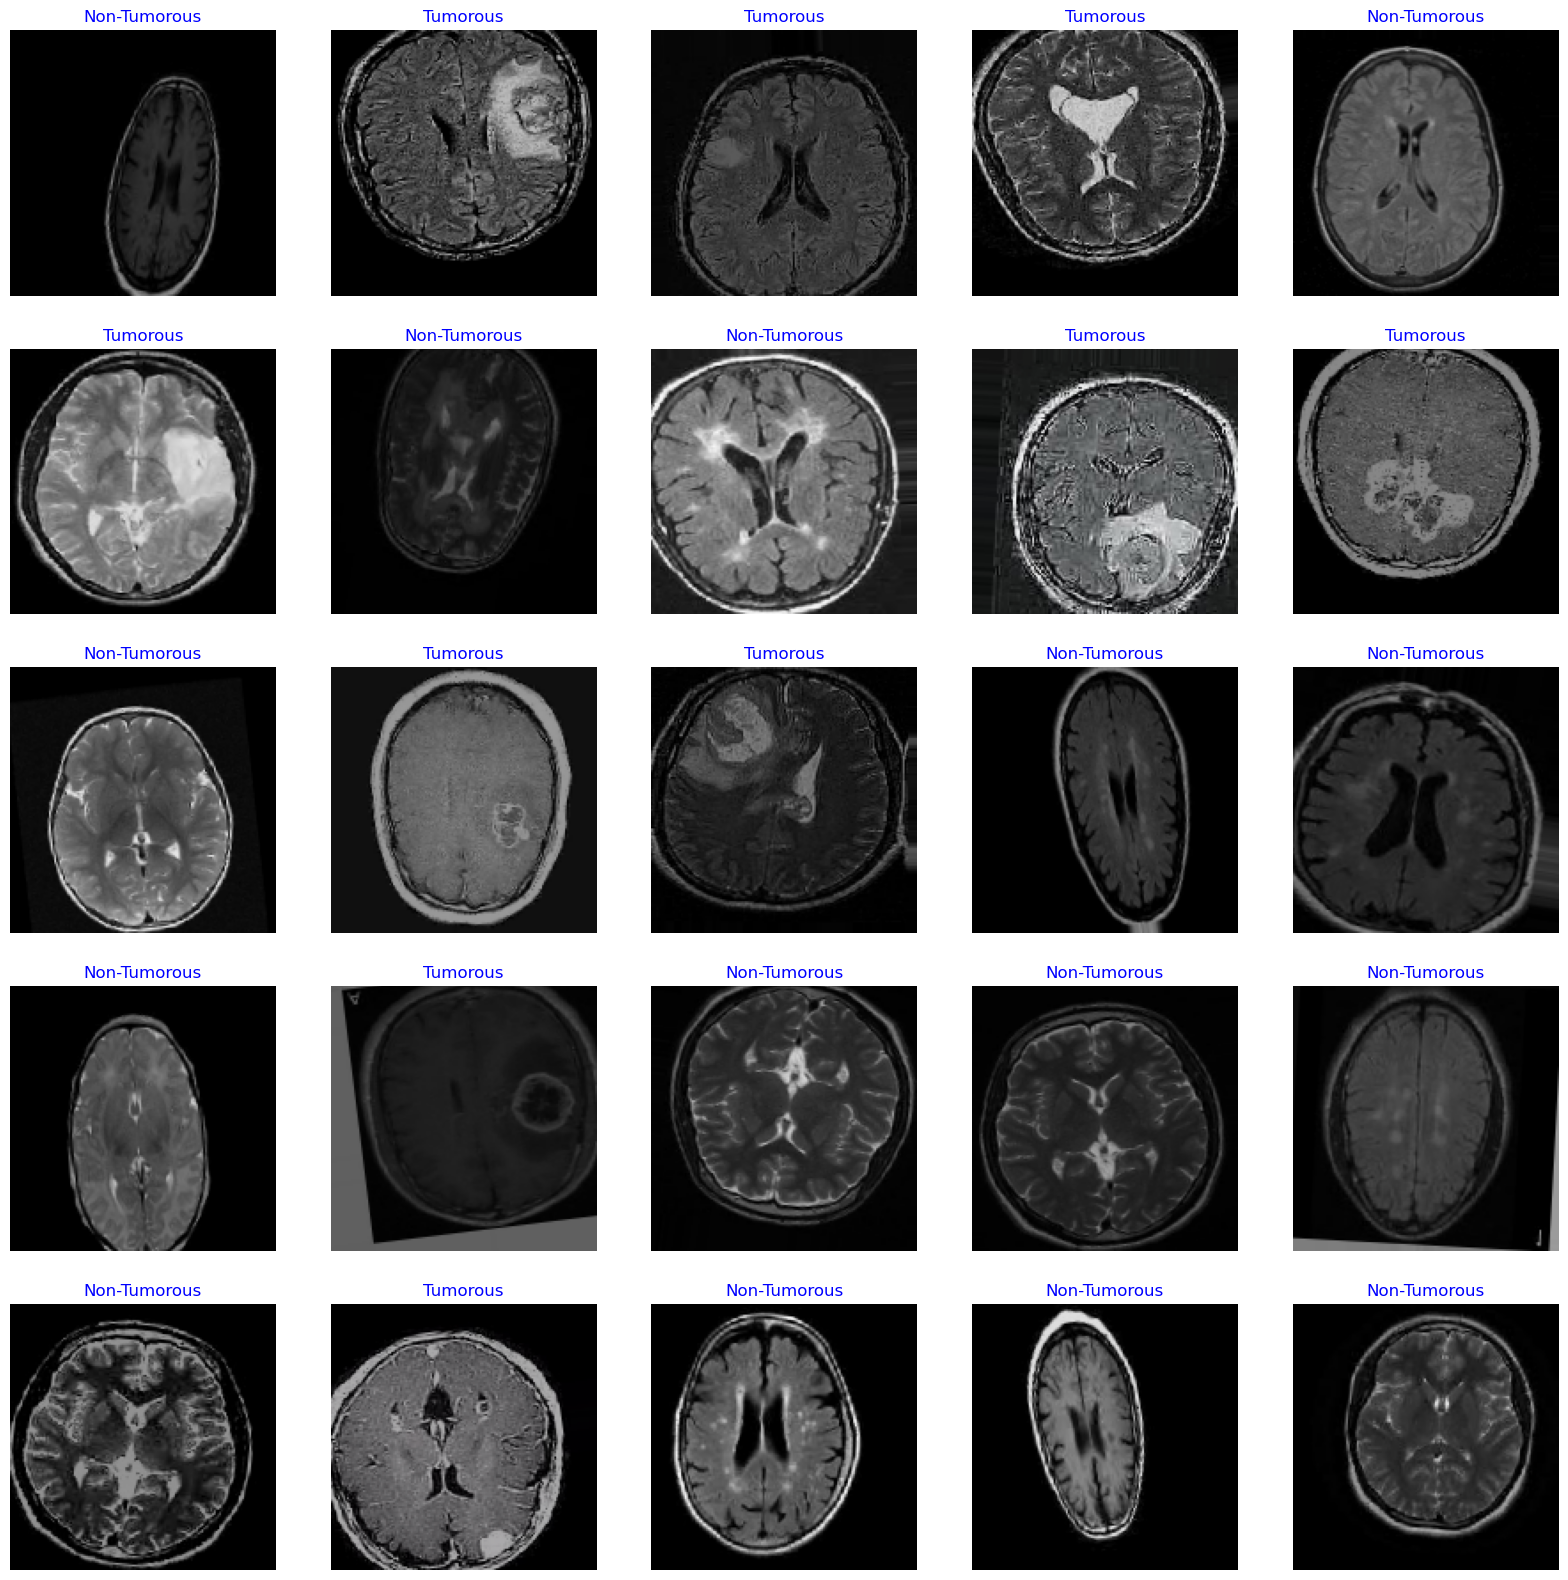

In [25]:
show_image_samples(train_generator)